In [ ]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from dataloader.dataloader import DataLoader
from preprocessing.clustering_segmentation import ClusteringSegmentation
from preprocessing.edge_detection import EdgeDetection
from preprocessing.image_restoration import ImageRestorer
from preprocessing.preproccessing import ImagePreprocessor
from preprocessing.region_segmentation import RegionBasedSegmentation
from preprocessing.threshold_segmentation import ThresholdSegmentation
from feature_extraction.feature_extraction import FeatureExtractor
from feature_selection.feature_selection import FeatureSelector
from model_selection.model_selection import ModelSelection
from performance_analysis.performance_analysis import PerformanceAnalysis

import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import numpy as np

## Data Loading

In [ ]:
dataloader = DataLoader(Path('./data'))

In [ ]:
# Load Data from files
x_train, y_train, x_test, y_test, x_val, y_val = dataloader.load_data()

In [ ]:
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")

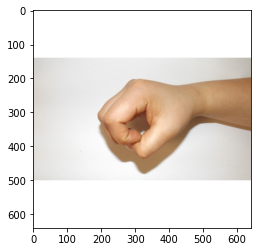

In [218]:
plt.imshow(x_train[800])
plt.show()

## Preprocessing

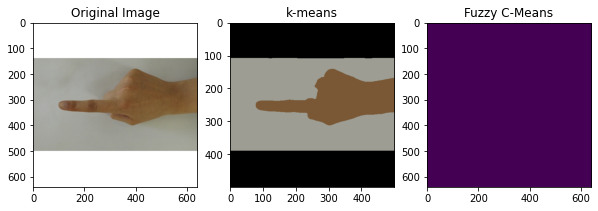

In [167]:
index = 810

# Method: 'kmeans' or 'canny'

clustering_segmentation = ClusteringSegmentation(method='kmeans', n_clusters=3, compactness=30.0, sigma=1.0)
kmeans = clustering_segmentation.process(x_train[index])
clustering_segmentation = ClusteringSegmentation(method='fcm', n_clusters=3, compactness=1.0, sigma=1.0)
fcm = clustering_segmentation.process(x_train[index])

fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].set_title('Original Image')
ax[1].set_title('k-means')
ax[2].set_title('Fuzzy C-Means')
ax[0].imshow(x_train[index])
ax[1].imshow(kmeans)
ax[2].imshow(fcm)
plt.show()

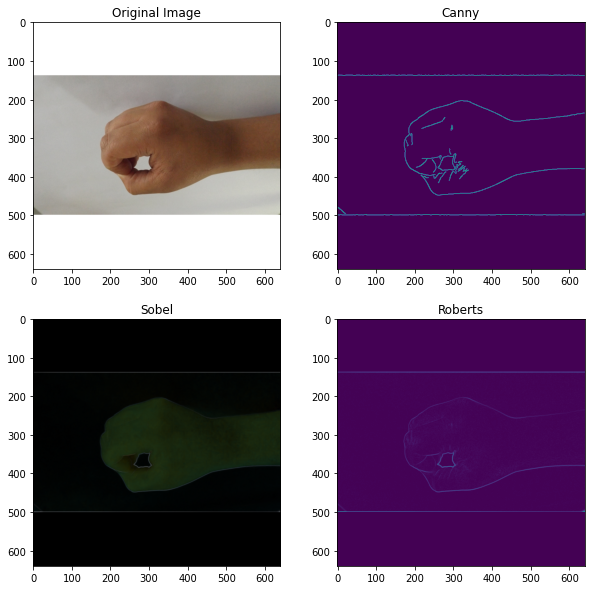

In [168]:
index = 747
# method: 'sobel', 'roberts', 'prewitt', 'canny'
edge_detection = EdgeDetection()

canny_image = edge_detection.canny(x_train[index], sigma=1.0, low_threshold=0.1, high_threshold=0.2)
sobel_image = edge_detection.sobel(x_train[index])
roberts_image = edge_detection.roberts(x_train[index])

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0,0].set_title('Original Image')
ax[0,1].set_title('Canny')
ax[1,0].set_title('Sobel')
ax[1,1].set_title('Roberts')
ax[0,0].imshow(x_train[index])
ax[0,1].imshow(canny_image)
ax[1,0].imshow(sobel_image)
ax[1,1].imshow(roberts_image)
plt.show()

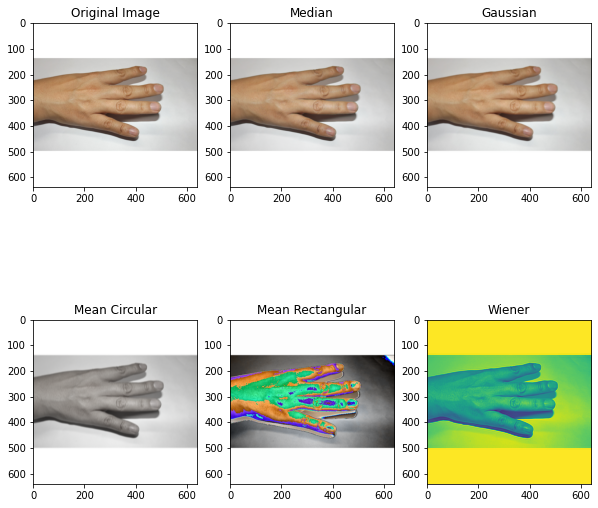

In [215]:
index = 451
#method: 'median', 'gaussian', 'mean_circular', 'mean_rectangular', 'wiener'
image_restorer = ImageRestorer(method='median')
median = image_restorer.process(x_train[index])
image_restorer = ImageRestorer(method='gaussian')
gaussian = image_restorer.process(x_train[index])
image_restorer = ImageRestorer(method='mean_circular')
mean_circular = image_restorer.process(x_train[index])
image_restorer = ImageRestorer(method='mean_rectangular')
mean_rectangular = image_restorer.process(x_train[index])
image_restorer = ImageRestorer(method='wiener')
wiener = image_restorer.process(x_train[index])
_, ax = plt.subplots(2, 3, figsize=(10, 10))
ax[0,0].set_title('Original Image')
ax[0,1].set_title('Median')
ax[0,2].set_title('Gaussian')
ax[1,0].set_title('Mean Circular')
ax[1,1].set_title('Mean Rectangular')
ax[1,2].set_title('Wiener')
ax[0,0].imshow(x_train[index])
ax[0,1].imshow(median)
ax[0,2].imshow(gaussian)
ax[1,0].imshow(mean_circular)
ax[1,1].imshow(mean_rectangular)
ax[1,2].imshow(wiener)
plt.show()

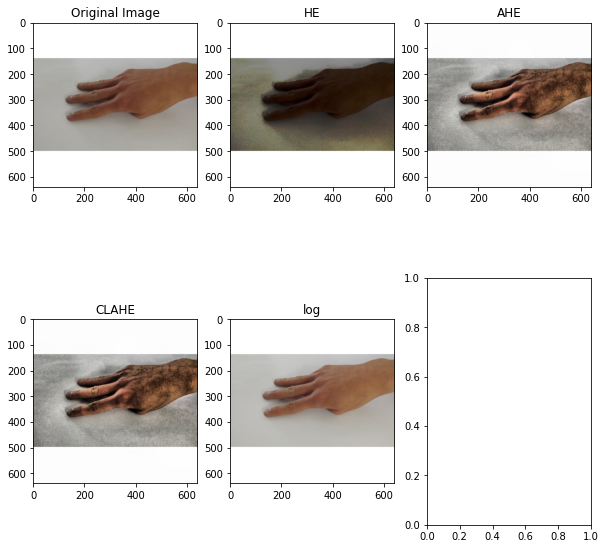

In [269]:
index = 478
# method: 'HE', 'AHE', 'CLAHE', 'log'
image_preprocessor = ImagePreprocessor(method = 'HE')
he = image_preprocessor.process(x_train[index])
image_preprocessor = ImagePreprocessor(method = 'AHE')
ahe = image_preprocessor.process(x_train[index])
image_preprocessor = ImagePreprocessor(method = 'CLAHE')
clahe = image_preprocessor.process(x_train[index])
image_preprocessor = ImagePreprocessor(method = 'log')
log_img = image_preprocessor.process(x_train[index])


_, ax = plt.subplots(2, 3, figsize=(10, 10))
ax[0,0].set_title('Original Image')
ax[0,1].set_title('HE')
ax[0,2].set_title('AHE')
ax[1,0].set_title('CLAHE')
ax[1,1].set_title('log')
ax[0,0].imshow(x_train[index])
ax[0,1].imshow(he)
ax[0,2].imshow(ahe)
ax[1,0].imshow(clahe)
ax[1,1].imshow(log_img)
plt.show()

In [ ]:
region_based_segmentation = RegionBasedSegmentation(method='region_merging')
# method: 'region_splitting' generates an error
plt.imshow(region_based_segmentation.process(x_train[0]))
plt.show()

## Features Extraction

In [ ]:
feature_extractor = FeatureExtractor()

# HOG FEATURES
hog_features = []
#10 images with label = 0
for i in range(10):
    hog_features.append(feature_extractor.extract_hog_features(x_train[i]))
# 10 images with label = 3
for i in range(1000, 1010):
    hog_features.append(feature_extractor.extract_hog_features(x_train[i]))
hog_features = np.array(hog_features)
print(f"hog_features shape: {hog_features.shape}")

# LCP FEATURES
lbp_features = []
for i in range(10):
    lbp_features.append(feature_extractor.extract_lbp_features(rgb2gray(x_train[i])))
lbp_features = np.array(lbp_features)
print(f"lbp_features shape: {lbp_features.shape}")


# SIFT FEATURES (error)
# sift_features = []
# for i in range(10):
#     sift_features.append(feature_extractor.extract_sift_features(X_train[i]))
# sift_features = np.array(sift_features)
# print(f"sift_features shape: {sift_features.shape}")

# FOURIER DESCRIPTOR FEATURES (error)
# fourier_descriptor_features = []
# for i in range(10):
#     fourier_descriptor_features.append(feature_extractor.extract_fourier_descriptor_features(X_train[i]))
# fourier_descriptor_features = np.array(fourier_descriptor_features)
# print(f"fourier_descriptor_features shape: {fourier_descriptor_features.shape}")

# SURF FEATURES (error)

surf_features = []
# for i in range(10):
#     surf_features.append(feature_extractor.extract_surf_features(X_train[i]))
# surf_features = np.array(surf_features)
# print(f"surf_features shape: {surf_features.shape}")

## Feature Selection

In [ ]:
feature_selector = FeatureSelector()

# PCA FEATURES
gray_imgs = rgb2gray(x_train)

pca_features =  feature_selector.extract_pca_features(gray_imgs,load=True)
print(f"pca_features shape: {pca_features.shape}")

## Model Selection

In [ ]:
# true_labels is just for trial here
true_labels = np.concatenate((np.zeros(10), np.ones(10) * 3))
model_selection = ModelSelection(
    hog_features[:15], true_labels[:15], hog_features[15:], true_labels[15:]
)
knn, pred_train, pred_val = model_selection.KNN()
print(pred_train)


## Performance Analysis

In [ ]:
performance_analysis = PerformanceAnalysis('KNN', pred_train, true_labels[15:])
performance_analysis.calculate_performance_metrics()